In [64]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
import os as os
import re as re
import pandas as pd

from motors.plot import *
from motors.aesthetics import prepare_plot
from motors.simulation import Simulation
from motors.analysis import return_concentration_slice

%matplotlib inline
%load_ext autoreload
%autoreload 2
prepare_plot()
cmap = sns.color_palette("Paired", 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compare the flux distribution of backbone and sidechain torsions

## Count the data

In [2]:
pka_data_directory = '../../md-data/pka-md-data/'
pka_apo = pka_data_directory + 'apo/'
pka_bound = pka_data_directory + 'atpmg/'

In [3]:
apo_all = glob(pka_apo + '*')
apo_phi = glob(pka_apo + 'phi*')
apo_psi = glob(pka_apo + 'psi*')
apo_omega = glob(pka_apo + 'omega*')

bound_all = glob(pka_bound + '*')
bound_phi = glob(pka_bound + 'phi*')
bound_psi = glob(pka_bound + 'psi*')

print(f'{len(apo_all)} total apo angles, {len(bound_all)} total bound angles in PKA dataset.')
print(f'{len(apo_phi)} phi angles, {len(apo_psi)} psi angles, {len(apo_omega)} omega angles in dataset.')

1341 total apo angles, 1341 total bound angles in PKA dataset.
336 phi angles, 336 psi angles, 0 omega angles in dataset.


There were no omega backbone angles calculated in this dataset, which matches my recollection.

## Load in the files for a quick spot check

In [4]:
def load_files(files):
    data = np.zeros((len(files), 60))
    for (index, file) in enumerate(files):
        datum = np.genfromtxt(file, delimiter=',', skip_header=1)
        data[index, :] = datum
    return data

In [574]:
apo_phi_files = load_files(apo_phi)
bound_phi_files = load_files(bound_phi)

apo_psi_files = load_files(apo_psi)
bound_psi_files = load_files(bound_psi)

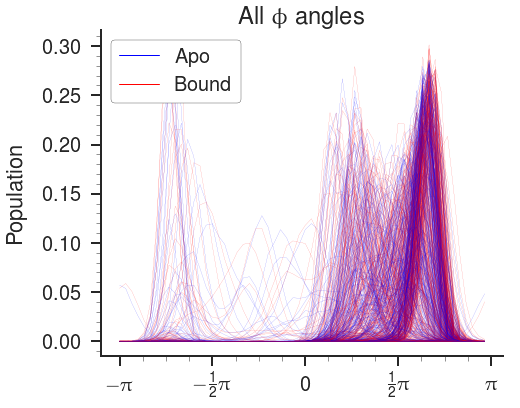

In [575]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])

for index, (apo, bound) in enumerate(zip(apo_phi_files, bound_phi_files)):
    ax1.plot(apo, c='b', lw=0.1, label='Apo' if index == 0 else '')
    ax1.plot(bound, c='r', lw=0.1, label='Bound' if index == 0 else '')
ax1.set_title(r'All $\phi$ angles')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels(
    [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)
for l in legend.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)

paper_plot(fig)

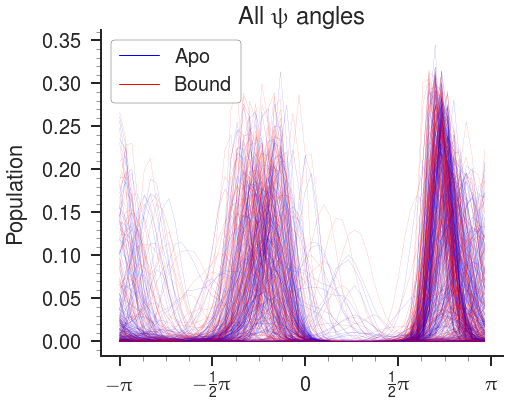

In [576]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax1 = plt.subplot(gs[0, 0])


for index, (apo, bound) in enumerate(zip(apo_psi_files, bound_psi_files)):
    ax1.plot(apo, c='b', lw=0.1, label='Apo' if index == 0 else '')
    ax1.plot(bound, c='r', lw=0.1, label='Bound' if index == 0 else '')
    
ax1.set_title(r'All $\psi$ angles')
ax1.set_xticks([0, 15, 30, 45, 60])
ax1.set_xticklabels(
    [r'$-\pi$', r'$-\frac{1}{2}\pi{}$', r'$0$', r'$\frac{1}{2}\pi$', r'$\pi$'])
ax1.set_ylabel(r'Population')
legend = ax1.legend(frameon=True, framealpha=1.0, edgecolor='k', loc=2)
for l in legend.get_lines():
    l.set_alpha(1)
    l.set_linewidth(1)

paper_plot(fig)

## Find a backbone angle with a very similar shape in bound protein conformations, for illustrative purposes...

In [213]:
df = pd.DataFrame()
apo_psi_files = glob(pka_apo + 'psi*')

for index, (apo, bound) in enumerate(zip(apo_psi, bound_psi)):
    # Subtract the difference between the two surfaces...
    difference = sum(apo - bound)
    df = df.append(pd.DataFrame({
        'Index' : index, 
        'File' : apo_psi_files[index],
        'Difference' : difference
    }, index=[0]), ignore_index=True)

In [225]:
df.ix[df['Difference'].idxmin()]['File']

'../../md-data/pka-md-data/apo/psiPHE333_chi_pop_hist_targ.txt'

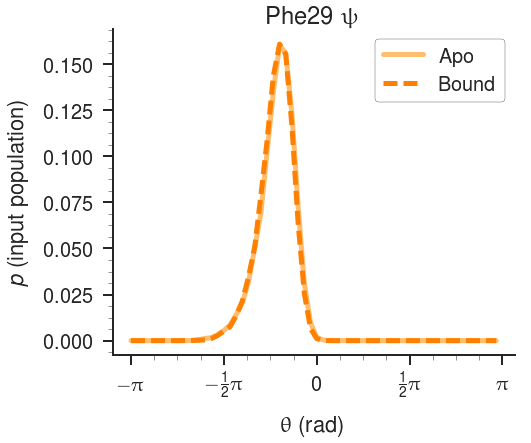

In [23]:
this = Simulation(data_source='pka_md_data')
this.name = 'psiPHE29'
this.cSubstrate = 10**-2.0
this.simulate()
plot_input(this, label=True, title=r'Phe29 $\psi$')

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         -1.30e-04  cycle second**-1
Peak                      +3.26e+00  cycle second**-1


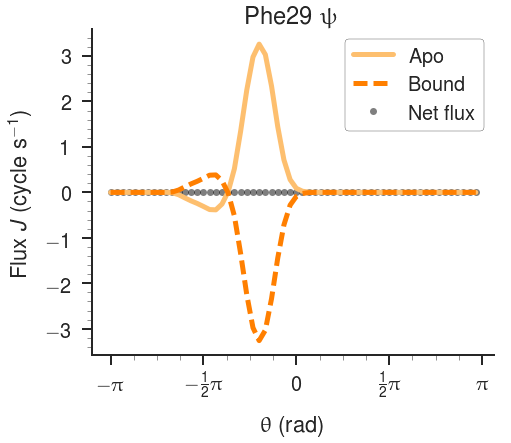

In [24]:
plot_flux(this, label=True, title=r'Phe29 $\psi$')

## Read in pre-computed data and separate the backbone torsions and sidechains...

In [46]:
calculation = False

In [74]:
if calculation:
    df = pd.DataFrame()

    pka_dir = '../../md-data/pka-md-data/'
    pka_files = sorted(glob(pka_dir + 'apo/' + '*'))
    names = []

    for file in range(len(pka_files)):
        name = os.path.splitext(os.path.basename(pka_files[file]))[0]
        name = re.search('^[^_]*', name).group(0)        
        if re.search('chi3ASN*', name):
            continue
        if re.search('chi5LYS*', name):
            continue
        if re.search('chi1CYM*', name):
            continue
        names.append(name)

    print(f'Found {len(names)} files...')

    for name in names:
        this = Simulation(data_source='pka_md_data')
        this.cSubstrate = 1.0
        this.name = name
        this.simulate()
        
        directional_flux = np.mean(this.flux_u + this.flux_b)
        # Make all flux on each surface positive
        unbound_flux = abs(this.flux_u)
        bound_flux = abs(this.flux_b)
        # Now find the maximum on either surface
        max_unbound = max(unbound_flux)
        max_bound = max(bound_flux)
        driven_flux = max([max_unbound, max_bound])

        df = df.append(pd.DataFrame({'Concentration': 1.0,
                                'Directional flux': directional_flux,
                                'Driven flux': driven_flux,
                                'File': name,
                                }, index=[0]), ignore_index=True)
else:
    pka_pickle = pd.read_pickle('../../motors/precomputed-pickles/pka-concentration-scan.pickle')
    pka = return_concentration_slice(pka_pickle, -2.0)

In [75]:
side_chains = pka[~pka.File.str.contains("phi|psi")]
back_bones = pka[pka.File.str.contains("phi|psi")]

## Filter the dataframes to look at "high flux" -- interesting -- torsions...

In [76]:
high_flux = pka[pka['Directional flux'].abs().values > 1]['Directional flux'].abs().values
high_flux_sc = side_chains[side_chains['Directional flux'].abs().values > 1]['Directional flux'].abs().values
high_flux_bb = back_bones[back_bones['Directional flux'].abs().values > 1]['Directional flux'].abs().values

In [77]:
print(f'{len(high_flux)} angles have high directional flux at this concentration.')
print(f'{len(high_flux_bb)} ({len(high_flux_bb) / len(high_flux) * 100:1.0f}%) backbone.')
print(f'{len(high_flux_sc)} ({len(high_flux_sc) / len(high_flux) * 100:1.0f}%) side chain.')

140 angles have high directional flux at this concentration.
38 (27%) backbone.
102 (73%) side chain.


## Look at percent backbone as a function of "high" flux threshold...

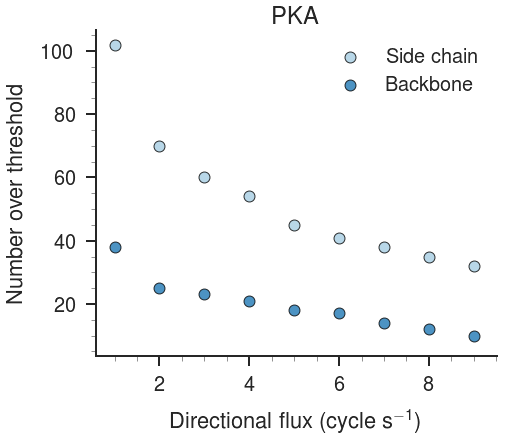

In [78]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

for index, threshold in enumerate(range(1, 10, 1)):
    threshold_flux = pka[pka['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    threshold_sc = side_chains[side_chains['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    threshold_bb = back_bones[back_bones['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    percent_bb = len(threshold_bb) / len(threshold_flux) * 100
    ax.scatter(threshold, len(threshold_sc), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[0], 
               label='Side chain' if index==0 else '')
    ax.scatter(threshold, len(threshold_bb), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[1], 
               label='Backbone' if index==0 else '')
ax.legend()
ax.set_title('PKA')
ax.set_ylabel('Number over threshold')
ax.set_xlabel('Directional flux (cycle s$^{{-1}}$)')
paper_plot(fig)

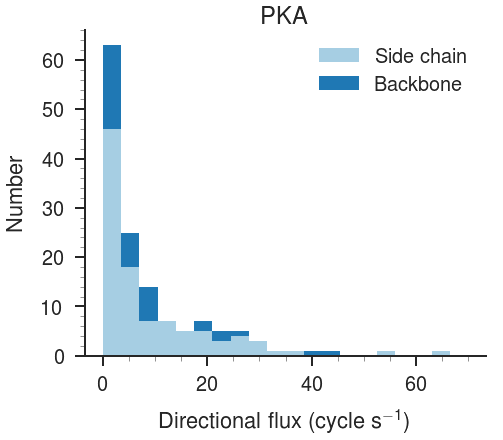

In [79]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

hist_sc, bin_edges = np.histogram(high_flux_sc, bins=20, range=(0,70))
mids = bin_edges[1:] - np.diff(bin_edges)/2
width = bin_edges[1] - bin_edges[0]
rects = ax.bar(mids, hist_sc, width=width, color=cmap[0], label='Side chain')
    
hist_bb, bin_edges = np.histogram(high_flux_bb, bins=20, range=(0,70))
mids = bin_edges[1:] - np.diff(bin_edges)/2
width = bin_edges[1] - bin_edges[0]
rects = ax.bar(mids, hist_bb, width=width, color=cmap[1], bottom=hist_sc, label='Backbone')

ax.legend()
ax.set_title('PKA')
ax.set_ylabel('Number')
ax.set_xlabel('Directional flux (cycle s$^{{-1}}$)')
paper_plot(fig)

Let's get the numbers for ADK and HIVP, too.

In [61]:
adk_pickle = pd.read_pickle('../../motors/precomputed-pickles/adk-concentration-scan.pickle')
adk = return_concentration_slice(adk_pickle, -2.0)

hivp_pickle = pd.read_pickle('../../motors/precomputed-pickles/hiv-high-catalytic-rate-200.pickle')
hivp = return_concentration_slice(hivp_pickle, -2.0)

In [62]:
for (protein, threshold) in zip([adk, hivp], [1, 1]):

    side_chains = protein[~protein.File.str.contains("phi|psi")]
    back_bones = protein[protein.File.str.contains("phi|psi")]
    print(f'{len(side_chains)} side chains and {len(back_bones)} backbones...')

    high_flux = protein[protein['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    high_flux_sc = side_chains[side_chains['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
    high_flux_bb = back_bones[back_bones['Directional flux'].abs().values > threshold]['Directional flux'].abs().values

    print(f'{len(high_flux)} angles have high directional flux at this concentration.')
    print(f'{len(high_flux_bb)} ({len(high_flux_bb) / len(high_flux) * 100:1.0f}%) backbone.')
    print(f'{len(high_flux_sc)} ({len(high_flux_sc) / len(high_flux) * 100:1.0f}%) side chain.')

477 side chains and 426 backbones...
140 angles have high directional flux at this concentration.
8 (6%) backbone.
132 (94%) side chain.
421 side chains and 394 backbones...
46 angles have high directional flux at this concentration.
4 (9%) backbone.
42 (91%) side chain.


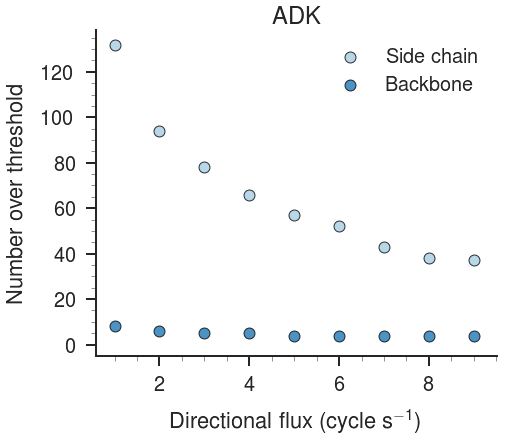

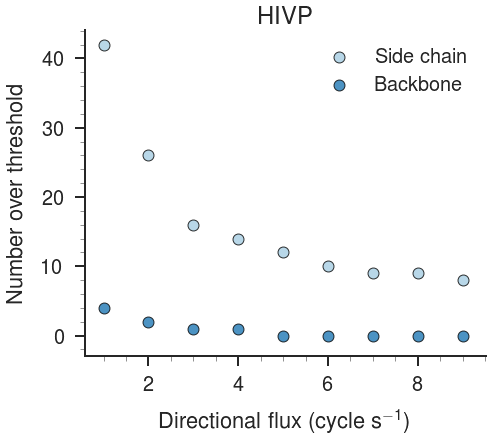

In [80]:
for protein in [adk, hivp]:
    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax = plt.subplot(gs[0, 0])
    
    side_chains = protein[~protein.File.str.contains("phi|psi")]
    back_bones = protein[protein.File.str.contains("phi|psi")]

    for index, threshold in enumerate(range(1, 10, 1)):
        high_flux = protein[protein['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
        high_flux_sc = side_chains[side_chains['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
        high_flux_bb = back_bones[back_bones['Directional flux'].abs().values > threshold]['Directional flux'].abs().values
        
        ax.scatter(threshold, len(high_flux_sc), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[0], 
                   label='Side chain' if index==0 else '')
        ax.scatter(threshold, len(high_flux_bb), marker='o', edgecolor='k', linewidth=1, alpha=0.8, s=120, c=cmap[1], 
                   label='Backbone' if index==0 else '')
    ax.legend()
    ax.set_title('ADK' if protein is adk else 'HIVP')
    ax.set_ylabel('Number over threshold')
    ax.set_xlabel('Directional flux (cycle s$^{{-1}}$)')
    paper_plot(fig)

## Pick a random backbone angle that has "high flux" and investigate...

In [582]:
high_flux[high_flux['File'].str.contains('psi')].head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
54604,-2.0,-6.930801,108.175771,psiALA110,20.707825,-0.00005,0.000175,110
54629,-2.0,-1.143464,12.651134,psiARG180,5.601375,-0.01799,0.010031,180
54635,-2.0,-1.984581,29.652094,psiARG322,8.207853,-0.01899,0.018574,322
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,0.035493,269
54647,-2.0,4.387149,47.312053,psiASN312,11.455164,0.00169,0.003722,312


Let's look at psiALA110...

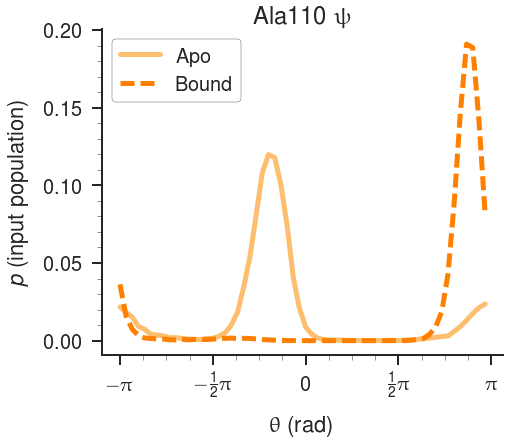

In [14]:
this = Simulation(data_source='pka_md_data')
this.cSubstrate = 10**-2.0
this.name = 'psiALA110'
this.simulate()
plot_input(this, label=True, title=r'Ala110 $\psi$')

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         -6.93e+00  cycle second**-1
Peak                      +1.01e+02  cycle second**-1


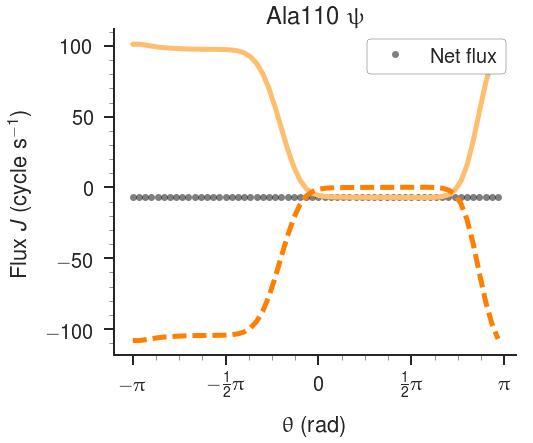

In [17]:
plot_flux(this, label=False, title=r'Ala110 $\psi$')

# Find how much work can be produced by a cycle of reciprocating motion

In [466]:
pka[pka['Driven flux'] > 10].sort_values('Driven flux').head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53959,-2.0,-0.000400,10.001350,chi2GLU107,3.036241,0.00000,0.000000e+00,107
54246,-2.0,-0.068681,10.011068,chi4LYS271,1.853816,0.00000,0.000000e+00,271
54409,-2.0,0.000149,10.036953,phiILE195,3.192221,0.00000,0.000000e+00,195
54070,-2.0,-0.360129,10.086928,chi2LYS67,3.331340,0.00000,0.000000e+00,67
54407,-2.0,-0.000098,10.089635,phiILE160,4.972032,-0.00001,2.815827e-10,160


In [31]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 0.01148320
Reciprocating flux = 113.43909098


C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.15e-02  cycle second**-1
Peak                      +1.13e+02  cycle second**-1


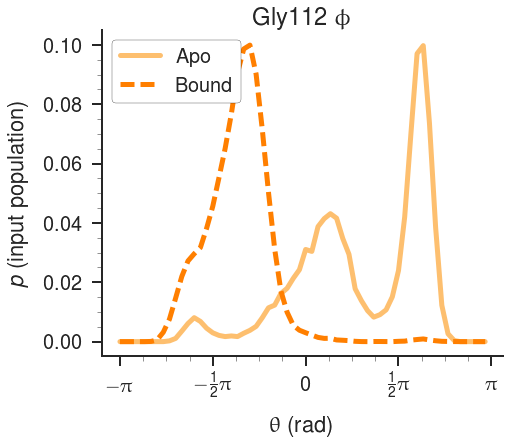

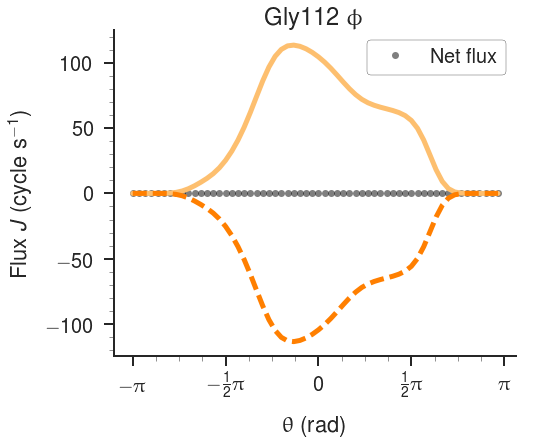

In [32]:
plot_input(this, label=True, title=r'Gly112 $\phi$')
plot_flux(this, title=r'Gly112 $\phi$')

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.47e+02  cycle second**-1
Peak                      +1.45e+02  cycle second**-1
-------------------------
Applied load              -7.00e-01  kcal mol**-1 cycle**-1
Power generated           -1.03e+02  kcal mol**-1 second**-1


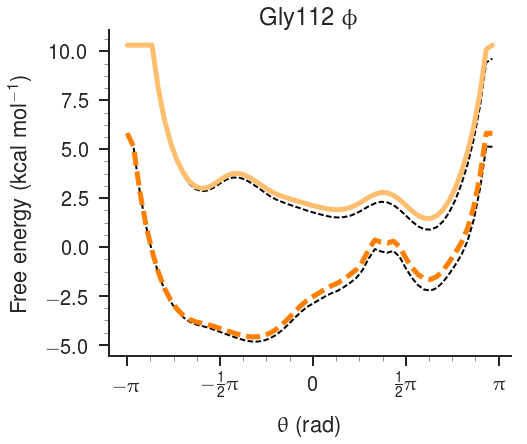

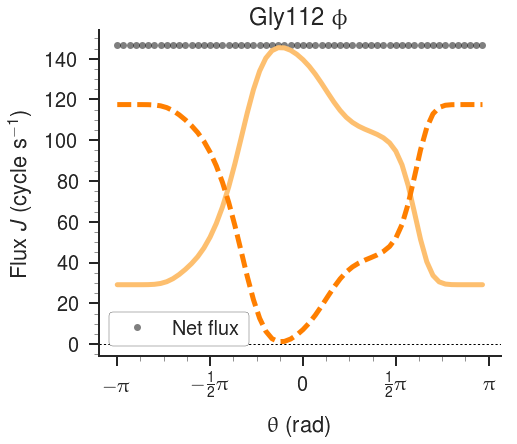

In [44]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = True
this.load_slope = -0.7
this.simulate()
plot_load(this, label=False, title=r'Gly112 $\phi$')
plot_flux(this, label=False, title=r'Gly112 $\phi$', zero_crossing=True)

What is the torsion that can support the maximum load?

In [54]:
pka.reindex(pka['Max load'].abs().sort_values(ascending=False).index).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,14.753445,194
53632,-2.0,30.125165,42.925922,chi1ASP152,8.379632,0.30099,4.441574,152
53792,-2.0,-9.097641,84.636100,chi1PHE140,22.102186,-0.27099,1.208986,140
54921,-2.0,-24.842157,92.932294,psiVAL109,15.664651,-0.22099,2.767213,109
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342,157


Remember that due poor labeling (my fault), the column `Max load` is actually the applied load at the maximum power, which we know to be half the stall load. To confirm...

/home/dslochower/hgst-3tb-data/projects/nonequilibrium-master/motors/simulation.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.89e+00  cycle second**-1
Peak                      +8.92e+01  cycle second**-1
-------------------------
Applied load              -8.40e-01  kcal mol**-1 cycle**-1
Power generated           -1.59e+00  kcal mol**-1 second**-1


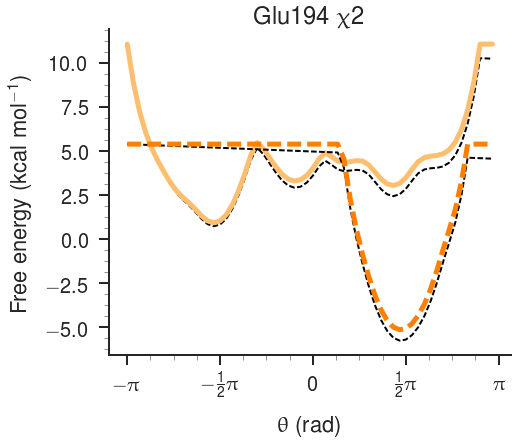

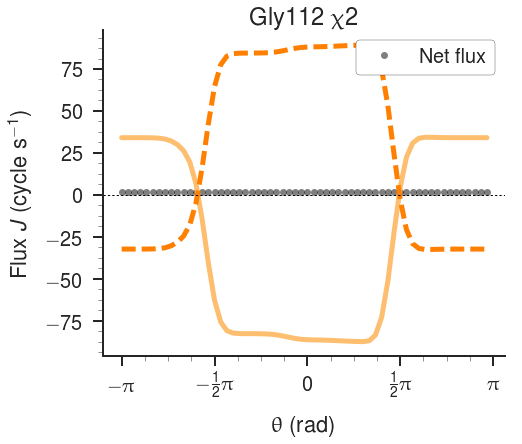

In [56]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2GLU194'
this.cSubstrate = 10**-2.0
this.load = True
this.load_slope = -0.84
this.simulate()
plot_load(this, label=False, title=r'Glu194 $\chi$2')
plot_flux(this, label=False, title=r'Gly112 $\chi$2', zero_crossing=True)

In [500]:
# pka.sort_values(by='Max power', ascending=False)
pka.reindex(pka['Max power'].abs().sort_values(ascending=False).index).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,14.753445,194
53632,-2.0,30.125165,42.925922,chi1ASP152,8.379632,0.30099,4.441574,152
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842,194
54921,-2.0,-24.842157,92.932294,psiVAL109,15.664651,-0.22099,2.767213,109
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342,157


In [501]:
pka.reindex(pka['Driven flux'].abs().sort_values(ascending=False).index).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342e+00,157
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842e+00,194
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,1.475344e+01,194
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,3.549260e-02,269
54377,-2.0,0.012270,113.439102,phiGLY112,12.143105,0.00003,1.880635e-07,112


In [502]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2ASN157'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 14.32191781
Reciprocating flux = 128.19059104


In [504]:
pka.sort_values(['Driven flux', 'Directional flux'], ascending=[False, True]).head()

,Concentration,Directional flux,Driven flux,File,Intersurface flux,Max load,Max power,ResID
53912,-2.0,14.322103,128.190265,chi2ASN157,16.743861,0.18099,1.316342e+00,157
53672,-2.0,-30.661092,127.154896,chi1GLU194,31.093582,-0.18099,2.795842e+00,194
53967,-2.0,-65.123967,125.798377,chi2GLU194,30.024953,-0.43099,1.475344e+01,194
54643,-2.0,3.136895,122.267383,psiASN269,16.101374,0.02299,3.549260e-02,269
54377,-2.0,0.012270,113.439102,phiGLY112,12.143105,0.00003,1.880635e-07,112


In [505]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = False
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
print(f'Directional flux = {directional_flux:0.8f}')
print(f'Reciprocating flux = {reciprocating_flux:0.8f}')

Directional flux = 0.01148320
Reciprocating flux = 113.43909098


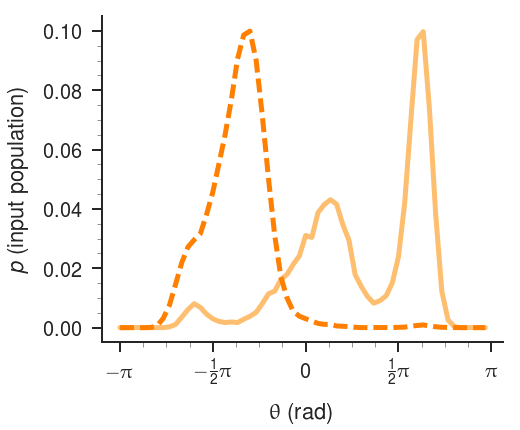

In [508]:
plot_input(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.15e-02  cycle second**-1
Peak                      +1.13e+02  cycle second**-1


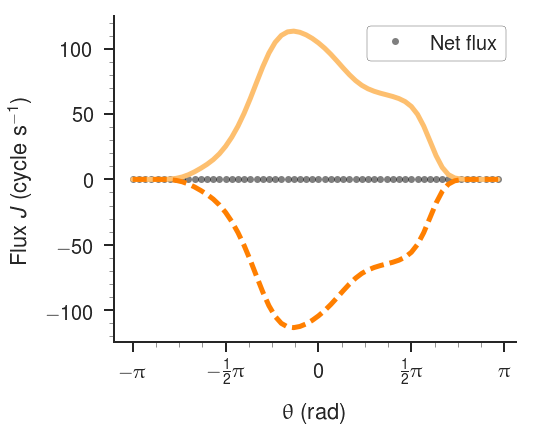

In [510]:
plot_flux(this)

C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +1.47e+02  cycle second**-1
Peak                      +1.45e+02  cycle second**-1
-------------------------
Applied load              -7.00e-01  kcal mol**-1 cycle**-1
Power generated           -1.03e+02  kcal mol**-1 second**-1


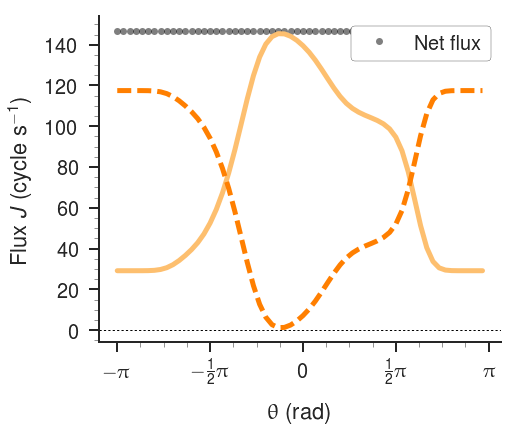

In [538]:
this = Simulation(data_source='pka_md_data')
this.name = 'phiGLY112'
this.cSubstrate = 10**-2.0
this.load = True
this.load_slope = -0.7
this.simulate()

plot_flux(this)

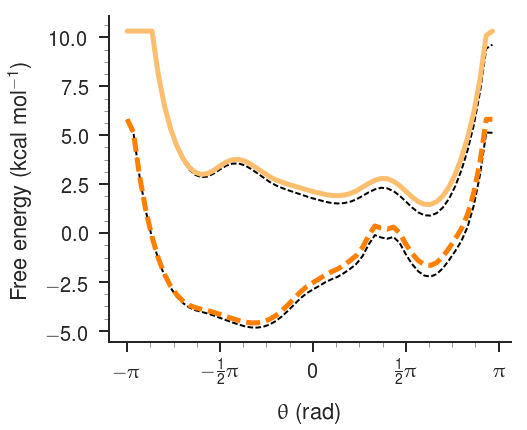

In [539]:
plot_load(this)

# Quick check...

In [560]:
for load_slope in np.arange(0, -0.7, -0.01):

    this = Simulation(data_source='pka_md_data')
    this.name = 'phiGLY112'
    this.cSubstrate = 10**-2.0
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    print(f'{load_slope:+2f}\t{np.min(this.flux_b):+2f}\t{np.min(this.flux_b) * load_slope:+2f}')

+0.000000	-113.427417	-0.000000
-0.010000	-112.169777	+1.121698
-0.020000	-110.903339	+2.218067
-0.030000	-109.628576	+3.288857
-0.040000	-108.345013	+4.333801
-0.050000	-107.052485	+5.352624
-0.060000	-105.755132	+6.345308
-0.070000	-104.443746	+7.311062
-0.080000	-103.129528	+8.250362
-0.090000	-101.803024	+9.162272
-0.100000	-100.467493	+10.046749
-0.110000	-99.126167	+10.903878
-0.120000	-97.776742	+11.733209
-0.130000	-96.411901	+12.533547
-0.140000	-95.041152	+13.305761
-0.150000	-93.660849	+14.049127
-0.160000	-92.271666	+14.763467
-0.170000	-90.868220	+15.447597
-0.180000	-89.460796	+16.102943
-0.190000	-88.041024	+16.727795
-0.200000	-86.609388	+17.321878
-0.210000	-85.171079	+17.885927
-0.220000	-83.718160	+18.417995
-0.230000	-82.258183	+18.919382
-0.240000	-80.787229	+19.388935
-0.250000	-79.300972	+19.825243
-0.260000	-77.810738	+20.230792
-0.270000	-76.304900	+20.602323
-0.280000	-74.785922	+20.940058
-0.290000	-73.259136	+21.245149
-0.300000	-71.718639	+21.515592
-0.3100

In [562]:
for load_slope in np.arange(0, 1.5, 0.05):

    this = Simulation(data_source='pka_md_data')
    this.name = 'phiGLY112'
    this.cSubstrate = 10**-2.0
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    print(f'{load_slope:+0.2f}\t{np.max(this.flux_u):+0.2f}\t{np.max(this.flux_u) * load_slope:+0.2f}')

+0.00	+113.44	+0.00
+0.05	+110.87	+5.54
+0.10	+108.24	+10.82
+0.15	+105.55	+15.83
+0.20	+102.79	+20.56
+0.25	+99.97	+24.99
+0.30	+97.07	+29.12
+0.35	+94.10	+32.94
+0.40	+91.05	+36.42
+0.45	+87.91	+39.56
+0.50	+84.75	+42.37
+0.55	+81.49	+44.82
+0.60	+78.14	+46.88
+0.65	+74.68	+48.54
+0.70	+71.11	+49.78
+0.75	+67.43	+50.57
+0.80	+63.63	+50.91
+0.85	+59.71	+50.75
+0.90	+55.66	+50.09
+0.95	+51.47	+48.90


/home/dslochower/hgst-3tb-data/projects/nonequilibrium-master/motors/simulation.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


+1.00	+47.14	+47.14
+1.05	+42.67	+44.80
+1.10	+38.04	+41.84
+1.15	+33.25	+38.24
+1.20	+28.30	+33.96
+1.25	+23.18	+28.98
+1.30	+17.88	+23.25
+1.35	+12.40	+16.74
+1.40	+6.73	+9.42
+1.45	+0.86	+1.24


/home/dslochower/hgst-3tb-data/projects/nonequilibrium-master/motors/simulation.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


C                         +2.40e+05  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +1.40e+02  second**-1
[S]                       +1.00e-02  M         
dt                        +1.00e-12  second    
-------------------------
Intrasurface flux         +9.00e-01  cycle second**-1
Peak                      +8.89e+01  cycle second**-1
-------------------------
Applied load              -8.30e-01  kcal mol**-1 cycle**-1
Power generated           -7.47e-01  kcal mol**-1 second**-1


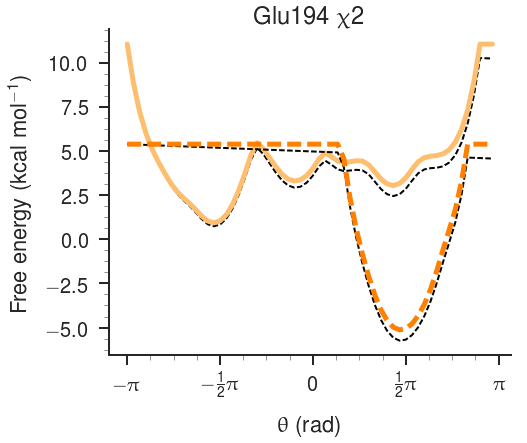

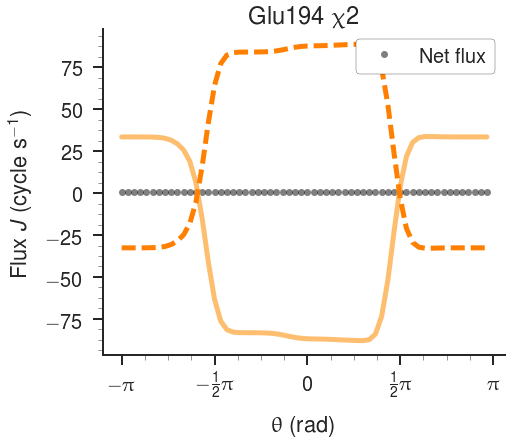

In [86]:
this = Simulation(data_source='pka_md_data')
this.name = 'chi2GLU194'
this.cSubstrate = 10**-2.0
this.load = True
this.load_slope = -0.83
this.simulate()

directional_flux = np.mean(this.flux_u + this.flux_b)
reciprocating_flux = np.max(np.hstack((abs(this.flux_u), abs(this.flux_b))))
plot_load(this, label=False, title=r'Glu194 $\chi$2')
plot_flux(this, label=False, title=r'Glu194 $\chi$2', zero_crossing=False)